# Analysis of GTR data for subject classification

* **Goal**: To classify research entities (organisations, universities, centres) into disciplines. This is based in the idea that the portfolio of activites of an organisation in GTR reflects their disciplinary profile and specialisation.
 * *Subgoals*
   * Determine variables for classification: research subject, research topic?
   * Determine right unit of analyis: institution, location, centre, individual?
   * Determine classification formula: how do we assign units to disciplines?

* **Outputs**: Organisation metadata we can use to look at interesting questions:
 *  What are the levels of collaboration between organisations with different specialisations?
 *  What are the levels of disciplinary specialisation in different regions? 
   * Some of this could be purely be done at the area level: e.g. counts of papers by topic and region. It wouldn't require institutional classification.
   
* **Other ideas**: 
 * Use community detection in the collaboration network to detect communities.
 * Topic modelling of user profiles to define subsectors. We'll probably need to do this anyway.

In [1]:
%matplotlib inline

#Imports
import json
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns

#For network analysis and community detection
from itertools import combinations
import networkx as nx
import community #Get this package: http://perso.crans.org/aynaud/communities/

#Path for visual outputs:
out_path = "/Users/juanmateos-garcia/Desktop/Arloesiadur/data_work/outputs/"


In [2]:
#Create connection with our database
#Steps
#Load config file
with open("../scripts/config.json",'r') as f:
    config = json.load(f)

#Create connection string
conn_string = 'host={} dbname={} user={} password={}'.format(
                    config.get("host"),
                    config.get("database"),
                    config.get("user"),
                    config.get("passw"))
#Create connection
conn = psycopg2.connect(conn_string)

In [3]:
#Read the data
#We'll read it in chunks
chunk= 500

#Create sql query string
sql_query_str="""
    SELECT
        *
    FROM
        gtr.projects      
"""

#Read the data
results = pd.read_sql(sql_query_str,con=conn,chunksize=chunk)

In [4]:
#Create df from results
projects_df = pd.DataFrame()
for result in results:
     projects_df = projects_df.append(result)

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

#reindex
projects_df.reset_index(drop=True,inplace=True)

#Select relevant columns and subset
rel_vars = ['pkey','abstract_texts','grant_cats','href','identifiers',
            'lead_org_dpts','links','research_subjects','research_topics','status']
projects_rel_df = projects_df[rel_vars]

#Extract the json elements form their 1 element-dicts
projects_rel_df['research_subjects'] = projects_rel_df[
    'research_subjects'].map(lambda x: x['researchSubject'])

projects_rel_df['research_topics'] = projects_rel_df[
    'research_topics'].map(lambda x: x['researchTopic'])

## Initial EDA
We want to understand the data better:

* How many subjects and topics are there for project?
* How many projects have subjects and/or topics?
* Which types of projects have this information?

In [6]:
#How many projects have a subject?
print("{}% of projects have research subject data".format(
    np.round(100*np.sum([len(i)>0 for i in projects_rel_df['research_subjects']])/float(len(
    projects_rel_df))),2))
#And a topic?
print("{}% of projects have research topic data".format(
    np.round(100*np.sum([len(i)>0 for i in projects_rel_df['research_topics']])/float(len(
    projects_rel_df))),2))

46.0% of projects have research subject data
46.0% of projects have research topic data


In [7]:
#Which types of project have a subject?
has_subject = projects_rel_df['research_subjects'].apply(lambda x: len(x)>0)
pd.crosstab(projects_rel_df['grant_cats'],has_subject).sort(True,ascending=False)[:10]

#Understandably, innovate_uk funded activities don't have a subject. But also
    #some research fellowships and research grants don't have a subject. Does
        #this follow any pattern?

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


research_subjects,False,True
grant_cats,,
Research Grant,10307,27241
Fellowship,1588,2999
"Business, Innovation & Skills Financed",78,0
Other Grant,204,0
Training Grant,6276,0
Third Party Grant,9,0
Studentship,874,0
Smart - Proof of Market,609,0
Smart - Proof of Concept,800,0


In [8]:
#Focus analysis on research grant and fellowship projects
#Subset
projects_academic_df = projects_rel_df[[i in ['Research Grant','Fellowship'] for
                                                 i in projects_rel_df.grant_cats]]
        
#Status of a project doesn't seem to explain missing subject.
pd.crosstab(projects_academic_df['status'],has_subject)

#What about department?
inst_subject_ctab = pd.crosstab(
    projects_academic_df['lead_org_dpts'],has_subject)
inst_subject_ctab['non_subject_perc']=inst_subject_ctab[False]/inst_subject_ctab.sum(axis=1)

#Seem to be primarily biological sciences/medicine departments
inst_subject_ctab.sort(False,ascending=False)[:10]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


research_subjects,False,True,non_subject_perc
lead_org_dpts,,,
Life Sciences,380,249,0.604134
Unlisted,342,168,0.670588
Chemistry,226,1195,0.159043
UNLISTED,220,22,0.909091
Biological Sciences,213,195,0.522059
Dept of Medicine,209,15,0.933036
School of Life Sciences,208,149,0.582633
Biochemistry,196,71,0.734082
Sch of Biological Sciences,181,176,0.507003


In [9]:
#How many unique lead departments are there?
print("{} unique strings for lead organisation departments".
      format(projects_academic_df['lead_org_dpts'].nunique()))
projects_academic_df['lead_org_dpts'].value_counts()[1:10]

2246 unique strings for lead organisation departments


Physics                  1269
Physics and Astronomy     760
Computer Science          641
Life Sciences             629
Unlisted                  510
Earth Sciences            457
Geography                 449
Psychology                417
Biological Sciences       408
Name: lead_org_dpts, dtype: int64

In [10]:
#Only consider projects with subject data (drop nas and )
projects_w_subject_df = projects_academic_df[projects_academic_df.research_subjects.notnull()]
projects_w_subject_df = projects_academic_df[[len(i)>0 for i in
                                             projects_academic_df.research_topics]]

#Extract research subjects and research topics.
projects_w_subject_df['subject_list'] = [[i['text'] for i in sublist] for sublist in 
                                       projects_w_subject_df['research_subjects']]
projects_w_subject_df['topic_list'] = [[i['text'] for i in sublist] for sublist in 
                                       projects_w_subject_df['research_topics']]

projects_w_subject_df.head()

,pkey,abstract_texts,grant_cats,href,identifiers,lead_org_dpts,links,research_subjects,research_topics,status,subject_list,topic_list
0,51709,The widely acclaimed writer W.G. Sabald is oft...,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/3EBF...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Modern Languages and Cultures,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Languages & Literature', u'percen...","[{u'text': u'German, inc. Dutch & Yiddish', u'...",Closed,[Languages & Literature],"[German, inc. Dutch & Yiddish]"
2,51711,Highly concentrated photovoltaic (HCPV) system...,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/3F0F...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Mechanical Engineering,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Energy', u'percentage': 100, u'id...","[{u'text': u'Solar Technology', u'percentage':...",Active,[Energy],[Solar Technology]
3,51712,"This multi-partner, bi-lingual community herit...",Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/74A9...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",School of Arts and Humanities,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'History', u'percentage': 0, u'id'...","[{u'text': u'Economic & Social History', u'per...",Closed,[History],[Economic & Social History]
6,51715,Autism Spectrum Conditions (ASCs) are neurodev...,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/76F1...,"{u'identifier': [{u'type': u'RCUK', u'value': ...","Culture, Communication and Media","{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Education', u'percentage': 20, u'...","[{u'text': u'Artificial Intelligence', u'perce...",Closed,"[Education, Info. & commun. Technol.]","[Artificial Intelligence, Human-Computer Inter..."
7,51716,Given a Fortran program which evaluates numeri...,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/9B8A...,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Science and Technology RI,"{u'link': [{u'otherAttributes': {}, u'href': u...","[{u'text': u'Info. & commun. Technol.', u'perc...","[{u'text': u'Fundamentals of Computing', u'per...",Closed,[Info. & commun. Technol.],[Fundamentals of Computing]


In [11]:
project_all_subjects = pd.Series([i for sublist in projects_w_subject_df['subject_list'] for
                       i in sublist])
projects_all_topics = pd.Series([i for sublist in projects_w_subject_df['topic_list'] for
                       i in sublist])

In [12]:
#NB "Tools, technologies and methods" seems to be a generic subject. We will drop it later.
subject_value_counts = project_all_subjects.value_counts()
print("There are {} unique subjects".format(len(subject_value_counts)))
subject_value_counts.head()

There are 82 unique subjects


Info. & commun. Technol.         3342
Tools, technologies & methods    2492
Climate & Climate Change         2089
Geosciences                      1876
Materials sciences               1789
dtype: int64

In [13]:
topic_value_counts = projects_all_topics.value_counts()
print("There are {} unique topics".format(len(topic_value_counts)))
topic_value_counts.head()

There are 607 unique topics


Climate & Climate Change      1947
Materials Characterisation    1470
Sociology                     1225
Psychology                    1076
Biogeochemical Cycles          962
dtype: int64

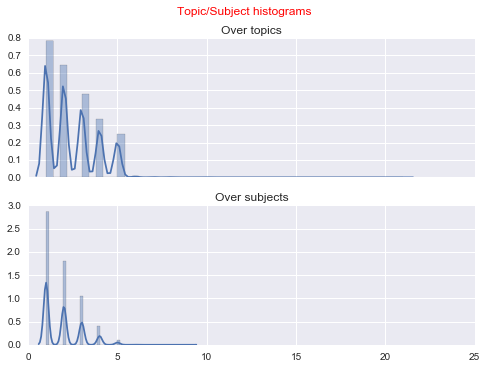

In [14]:
#Can we use co-occurrence of topics to create a taxonomy of topics and of subjects? 
#How often does it happen?
subject_n = pd.Series([len(i) for i in projects_w_subject_df['subject_list']])
topic_n = pd.Series([len(i) for i in projects_w_subject_df['topic_list']])

f, (ax1, ax2) = plt.subplots(2,sharex=True)
my_plot = sns.distplot(topic_n,ax=ax1)
my_plot.set_title("Over topics")
my_plot2 = sns.distplot(subject_n,ax=ax2)
my_plot2.set_title("Over subjects")
f.suptitle("Topic/Subject histograms",size=12,color='red')


## Community detection

* We create a network based on subject co-occurrences
* Perform community detection on the set of topics for each project in order to identify a smaller set.
* We can attach these to organisations and regions.

In [15]:
def extract_network_from_corpus(label_corpus,stop_words=None):
    """
    Extracts a network object from a corpus of documents with co-ocurring labels. 
    In the network, the labels are nodes and co-occurrences between them are edges. Weight is number of co-occurrences.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence.
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object that we can do things with (such as community detection)
    
    """
    #Container for pairs of labels
    label_pairs_container =[]
    
    #For each pair
    for i in label_corpus:
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(i,2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights
    label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']).size()).reset_index().sort(columns=0,ascending=False)
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)
    

In [16]:
#Extract communities (discipline aggregates)
subject_communities = community.best_partition(extract_network_from_corpus(projects_w_subject_df.subject_list,
                                              stop_words="Tools, technologies & methods"))
topic_communities = community.best_partition(extract_network_from_corpus(projects_w_subject_df.topic_list))


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [17]:
#The community objects are dicts where keys are subjects or topics, and values their communities
#Use this group dict to relabel variables
# !!! this ranking may change depending on the community detection analysis.
grouped_topics_dict = {0:"Social Sciences",
                      1:"Environmental Sciences",
                      2:"Life Sciences",
                      3:"Arts and Humanities",
                      4:"Physics",
                      5:"Mathematics and Computing",
                      6:"Engineering and Technology"}

In [18]:
#Lookup disciplines
#We use topics
projects_w_subject_df['aggregated_topics'] = projects_w_subject_df.topic_list.map(
    lambda x: [grouped_topics_dict[topic_communities[i]] for i in x])

#If there are more than 2 disciplines, we call the project Mixed (a.k.a. multi/interdisciplinary)
projects_w_subject_df['topic_classified'] = projects_w_subject_df['aggregated_topics'].map(
    lambda x: list(set(x))[0] if len(set(x))==1 else "Mixed")

#Check outputs
projects_w_subject_df.ix[1:10,['pkey','topic_list','aggregated_topics','topic_classified']]

,pkey,topic_list,aggregated_topics,topic_classified
2,51711,[Solar Technology],[Engineering and Technology],Engineering and Technology
3,51712,[Economic & Social History],[Arts and Humanities],Arts and Humanities
6,51715,"[Artificial Intelligence, Human-Computer Inter...","[Mathematics and Computing, Mathematics and Co...",Mixed
7,51716,[Fundamentals of Computing],[Mathematics and Computing],Mathematics and Computing
8,51717,[Data Handling & Storage],[Physics],Physics
9,51718,"[Climate & Climate Change, Pollution, Hydrolog...","[Environmental Sciences, Environmental Science...",Environmental Sciences
10,51719,"[Pollution, Boundary Layer Meteorology, Land -...","[Environmental Sciences, Environmental Science...",Environmental Sciences


In [19]:
#Join this with the project df
project_labelled_df = projects_df.merge(projects_w_subject_df[['pkey','topic_list','aggregated_topics','topic_classified']],
                                         on="pkey",how='left')
project_labelled_df.head()

,pkey,abstract_texts,created,grant_cats,href,health_categories,id,identifiers,lead_org_dpts,links,potential_impacts,research_activities,research_subjects,research_topics,status,titles,tech_abstracts,topic_list,aggregated_topics,topic_classified
0,51709,The widely acclaimed writer W.G. Sabald is oft...,2016-03-31 19:16:25,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/3EBF...,{u'healthCategory': []},3EBFD795-CD31-4850-9676-C08B769B3A46,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Modern Languages and Cultures,"{u'link': [{u'otherAttributes': {}, u'href': u...",None,{u'researchActivity': []},{u'researchSubject': [{u'text': u'Languages & ...,"{u'researchTopic': [{u'text': u'German, inc. D...",Closed,W.G. Sebald: Modernity and the Archive,None,"[German, inc. Dutch & Yiddish]",[Arts and Humanities],Arts and Humanities
1,51710,Lignin is a natural polymer in abundance and p...,2016-03-31 19:16:25,Innovation Voucher,http://gtr.rcuk.ac.uk:80/gtr/api/projects/3F0E...,{u'healthCategory': []},3F0EC91C-7E09-4EE7-ABEB-BE1BA33556A6,"{u'identifier': [{u'type': u'RCUK', u'value': ...",None,"{u'link': [{u'otherAttributes': {}, u'href': u...",None,{u'researchActivity': []},{u'researchSubject': []},{u'researchTopic': []},Closed,Lignin: Crop Intellect,None,NaN,NaN,NaN
2,51711,Highly concentrated photovoltaic (HCPV) system...,2016-03-31 19:16:25,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/3F0F...,{u'healthCategory': []},3F0F02FA-2942-4D17-A01E-BD3DD5C08B35,"{u'identifier': [{u'type': u'RCUK', u'value': ...",Mechanical Engineering,"{u'link': [{u'otherAttributes': {}, u'href': u...",The impact of our proposed international colla...,{u'researchActivity': []},"{u'researchSubject': [{u'text': u'Energy', u'p...",{u'researchTopic': [{u'text': u'Solar Technolo...,Active,Newton Fund-Integrating water cooled concentra...,None,[Solar Technology],[Engineering and Technology],Engineering and Technology
3,51712,"This multi-partner, bi-lingual community herit...",2016-03-31 19:16:25,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/74A9...,{u'healthCategory': []},74A9A074-1577-4116-82CD-D1A12178C5B7,"{u'identifier': [{u'type': u'RCUK', u'value': ...",School of Arts and Humanities,"{u'link': [{u'otherAttributes': {}, u'href': u...","First and foremost, the seven All our Stories ...",{u'researchActivity': []},"{u'researchSubject': [{u'text': u'History', u'...",{u'researchTopic': [{u'text': u'Economic & Soc...,Closed,Cymunedau Cysylltiedig 2: Researching the Indu...,None,[Economic & Social History],[Arts and Humanities],Arts and Humanities
4,51713,Fleetfoot is our driver engagement and behavio...,2016-03-31 19:16:25,Feasibility Study,http://gtr.rcuk.ac.uk:80/gtr/api/projects/74E1...,{u'healthCategory': []},74E11FB1-09B2-4A0D-92D9-D00DCC71799D,"{u'identifier': [{u'type': u'RCUK', u'value': ...",None,"{u'link': [{u'otherAttributes': {}, u'href': u...",None,{u'researchActivity': []},{u'researchSubject': []},{u'researchTopic': []},Active,Harnessing Driver Data in Rental Vehicles,None,NaN,NaN,NaN


In [20]:
#Add attributes to networkx and output for plotting
topic_network = extract_network_from_corpus(projects_w_subject_df.topic_list)

#Add labels
#For each label in a node
for i in topic_network.node:
    #Add a category attribute based on the grouped_topic_dict and topic_communities lookups
    
    topic_network.node[i]["category"] = grouped_topics_dict[topic_communities[i]]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [21]:
nx.write_graphml(topic_network,out_path+"topic_network_14may2016.graphml")

## Quick network graph via gephi

### Node size
* Degree centrality (number of edges with other topics)

### Colours = subjects
* Orange = Life sciences
* Blue = Engineering + Technology
* Red = Physics
* Dark brown = Environmental sciences
* Dark green = Maths and computing
* Light green = Arts and Humanities
* Purple = Social sciences

<img src="http://i.imgur.com/QdTsGW6.png">

In [22]:
#Code for creating an assortivity matrix.
mappd = {v:k for k,v in grouped_topics_dict.iteritems()}
am = nx.attribute_mixing_matrix(topic_network,attribute="category",mapping=mappd)

In [23]:
#Coming up:
#Flatten organisational info from the links field in projects_df, and merge with projects labelled. Once we
    #geo-code those (say by merging vs. organisations in the DB) we will have a dataframe ready to plot activity
    #regionally.
    #What is the relative specialisation of Welsh organisations vs. those in other parts of the UK?
    #How has this evolved over time?
    #What are the disciplines with more 'mixed' activity?
    #What are the institutions with more 'mixed' activity?
#We can also plot networks of collaboration (projects with the same id indicate an edge between organisations.
#We can map those.)
#Chart ideas:
#Network graphs using edge attributes to describe networks between institutions (can subset by location and 
#by network type.)
#Bubble charts with indexes of activity with businesses and internationally, and number of projects. Could be static or
#Dynamic (e.g. bokeh interactive chart)

In [24]:
#Merges to obtain a df with ids = project/organisation pairs 

#This will include project metadata i.e. topics and org metadata i.e. location.

#This involves:
#projects_df -> project_links (where we unpack all the orgs involved with each project)
#merge(project_links, lad_lut) -> project_links_geo_df (where we merge orgs with the LAD Lookup table)
#merge(project_links_geo_df, project_labelled_df) -> output

In [39]:
project_links_list = [i['link'] for i in projects_df['links']]

In [278]:
#Probably not the way to do this...
[i.update({"id":my_id}) for sublist,my_id in zip(project_links_list,projects_df['id']) for i in sublist]

In [47]:
#1 flatten the link field
#Extract data from link field in the projects_df
project_links_unpacked = [pd.DataFrame(i['link'])for i in projects_df['links']]
project_links_df = pd.concat(project_links_unpacked)

#Cleadn df
project_links_df.reset_index(inplace=True,drop=True)
project_links_df.drop('otherAttributes',axis=1,inplace=True)
project_links_df.rename(columns={"id":"project_id"},inplace=True)
project_links_df.head()

,end,href,project_id,rel,start
0,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/persons/A1978...,3EBFD795-CD31-4850-9676-C08B769B3A46,PI_PER,NaN
1,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,3EBFD795-CD31-4850-9676-C08B769B3A46,LEAD_ORG,NaN
2,1.154300e+12,http://gtr.rcuk.ac.uk:80/gtr/api/funds/14A7FBE...,3EBFD795-CD31-4850-9676-C08B769B3A46,FUND,1.146438e+12
3,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/outcomes/publ...,3EBFD795-CD31-4850-9676-C08B769B3A46,PUBLICATION,NaN
4,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/persons/1EB3E...,3F0EC91C-7E09-4EE7-ABEB-BE1BA33556A6,PM_PER,NaN


In [48]:
#Read and merge LAD LUT with project_links_df 
#(NB I had to read and write this in Python 3 due to backward incompatibility in encoding protocols)
lad_lut = pd.read_pickle("lut2.p")
lad_lut.reset_index(inplace=True,drop=True)
lad_lut.head()

,name,id,lad
0,E and F Composites Limited,817462B1-FD5F-475B-A052-FAD9B6D120C4,E06000001
1,Millfield Composites Limited,53F24C3A-6416-4433-B0D9-4C1008D7AF3F,E06000001
2,Frutarom (UK) Limited,7683EFB8-C180-4719-A428-11A75A7E8F19,E06000001
3,N W Brown T/A BC Environmental,9DA0F015-A0FA-4AD8-9D18-A4D3A3338E08,E06000001
4,Hartlepool City Learning Centre,C935197B-542D-4E68-ACD3-696FE724E7DF,E06000001


In [49]:
#Extract organisation id data
project_links_df['org_id'] = project_links_df['href'].map(lambda x: x.split("/")[-1])

#Merge with org addresses (!!! NB this merge only considers geo-coded organisations)
project_links_geo_df = pd.merge(project_links_df,
                               lad_lut,left_on="org_id",right_on="id",how="inner")
project_links_geo_df.head()

,end,href,project_id,rel,start,org_id,name,id,lad
0,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,3EBFD795-CD31-4850-9676-C08B769B3A46,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
1,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,662AEC23-1B71-47EA-9F84-D29D75C12CD7,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
2,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,9BF3CEC5-3892-42A1-B65F-FB0DE83E82C0,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
3,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,DAA6C296-9650-40DC-A561-F89664E54C58,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047
4,NaN,http://gtr.rcuk.ac.uk:80/gtr/api/organisations...,D7718929-7296-4CB0-89FC-FCCD1164EC81,LEAD_ORG,NaN,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,46B41008-0EB4-4E28-BBFB-E98366999EC5,E06000047


In [51]:
#Merge the geo-coded organisations with the original project df to create the project (topic) - org link. We will 
    #use this for mapping later
#!!! This still includes a bunch of innovate_uk projects. Can deal with this by removing projects with null topics.
relevant_proj_fields = ["grant_cats","href","id","status","titles","topic_list","aggregated_topics","topic_classified"]
relevant_org_fields = ['project_id','rel','org_id','name','lad']

projects_org_df = pd.merge(project_links_geo_df[relevant_org_fields],project_labelled_df[relevant_proj_fields],
                            left_on="project_id",right_on="id",how="inner",sort=False)


In [ ]:
#Create table for James.
#np.sum(['Swansea' in i for i in projects_org_df.name])

In [52]:
projects_org_df_short = projects_org_df[['project_id','rel','org_id','name','lad','topic_classified']]

In [53]:
projects_org_df_short.head()

,project_id,rel,org_id,name,lad,topic_classified
0,3EBFD795-CD31-4850-9676-C08B769B3A46,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Arts and Humanities
1,662AEC23-1B71-47EA-9F84-D29D75C12CD7,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Mathematics and Computing
2,9BF3CEC5-3892-42A1-B65F-FB0DE83E82C0,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Life Sciences
3,DAA6C296-9650-40DC-A561-F89664E54C58,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Engineering and Technology
4,D7718929-7296-4CB0-89FC-FCCD1164EC81,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Environmental Sciences


In [54]:
#Group everything by project ids
projects_org_grouped = projects_org_df_short.groupby("project_id")

#Create a container
projects_orgs_list = []

#Loop over project names and content of affiliated orgs
for name, group in projects_org_grouped:
    
    #Put everything in a dict
    proj_dict={}
    proj_dict['project_id'] = name
    proj_dict['topics'] = group.topic_classified.iloc[0]
    
    project_list=[]
    
    #Group inside the projct, by org
    org_grouped = group.groupby("org_id")
    
    for name,group in org_grouped:
        org_dict={}
        org_dict['org_id']=name
        org_dict['lad'] = group.lad.iloc[0]
        
        project_list.append(org_dict)
    
    proj_dict['orgs']=project_list
    projects_orgs_list.append(proj_dict)

In [56]:
with open('project_org.json','w') as outfile:
    json.dump(projects_orgs_list,outfile)

In [57]:
#Get geo-tags
#Downloaded lookup table from here: 
#https://geoportal.statistics.gov.uk/geoportal/catalog/content/filelist.page?redirect=Docs/
#Lookups/Local_authority_districts_(2013)_to_countries_(2013)_UK_lookup.zip&pos=4&cat=#
#LU_Local_authority_districts_(2013)_to_countries_(2013)_UK_lookup.zip

In [457]:
lad_lookup_path ='//Users/juanmateos-garcia/Desktop/Arloesiadur/'\
'data_work/metadata/Local_authority_districts_(2013)_to_countries_(2013)_UK_lookup/'\
'LAD13_CTRY13_UK_LU.csv'

#Read file
lad_country_lookup = pd.read_csv(lad_lookup_path)
print(lad_country_lookup.head())

#Create list of names for Welsh LADs
welsh_lads = list(lad_country_lookup.ix[lad_country_lookup.CTRY13NM=="Wales","LAD13NM"])
welsh_lads

#Merge with the lad_lut to create an organisation - country lookup
org_geo_lut = pd.merge(lad_lut,lad_country_lookup,left_on="lad",right_on="LAD13CD")
org_geo_lut.tail()

#Turn this into a dict for labelling nodes later
org_geo_lut_indexed = org_geo_lut.set_index("name",drop=True)
org_geo_lu_dict = pd.DataFrame.to_dict(org_geo_lut_indexed,orient="index")


     LAD13CD LAD13CDO               LAD13NM   CTRY13CD  CTRY13CDO CTRY13NM
0  E09000001     00AA        City of London  E92000001        921  England
1  E09000002     00AB  Barking and Dagenham  E92000001        921  England
2  E09000003     00AC                Barnet  E92000001        921  England
3  E09000004     00AD                Bexley  E92000001        921  England
4  E09000005     00AE                 Brent  E92000001        921  England


In [208]:
#Merge lookup with labelled projects df and projects df.
places_projects_orgs_df = pd.merge(projects_org_df,
                                 lad_country_lookup,left_on="lad",
                                 right_on="LAD13CD",how="left")
places_projects_orgs_df.rename(columns={'CTRY13NM': 'country','LAD13NM':'lad_name'},inplace=True)
places_projects_orgs_df.head()

,project_id,rel,org_id,name,lad,grant_cats,href,id,status,titles,topic_list,aggregated_topics,topic_classified,LAD13CD,LAD13CDO,lad_name,CTRY13CD,CTRY13CDO,country
0,3EBFD795-CD31-4850-9676-C08B769B3A46,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/3EBF...,3EBFD795-CD31-4850-9676-C08B769B3A46,Closed,W.G. Sebald: Modernity and the Archive,"[German, inc. Dutch & Yiddish]",[Arts and Humanities],Arts and Humanities,E06000047,00EJ,County Durham,E92000001,921,England
1,662AEC23-1B71-47EA-9F84-D29D75C12CD7,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/662A...,662AEC23-1B71-47EA-9F84-D29D75C12CD7,Closed,Mathematical Aspects of Graphical Models: An L...,[Statistics & Appl. Probability],[Mathematics and Computing],Mathematics and Computing,E06000047,00EJ,County Durham,E92000001,921,England
2,9BF3CEC5-3892-42A1-B65F-FB0DE83E82C0,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/9BF3...,9BF3CEC5-3892-42A1-B65F-FB0DE83E82C0,Active,The mechanistic basis of plant NLR signalling ...,"[Protein expression, Interaction with organism...","[Life Sciences, Life Sciences, Life Sciences]",Life Sciences,E06000047,00EJ,County Durham,E92000001,921,England
3,DAA6C296-9650-40DC-A561-F89664E54C58,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/DAA6...,DAA6C296-9650-40DC-A561-F89664E54C58,Active,Rydberg crystals and supersolids,[Cold Atomic Species],[Engineering and Technology],Engineering and Technology,E06000047,00EJ,County Durham,E92000001,921,England
4,D7718929-7296-4CB0-89FC-FCCD1164EC81,LEAD_ORG,46B41008-0EB4-4E28-BBFB-E98366999EC5,Durham University,E06000047,Research Grant,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D771...,D7718929-7296-4CB0-89FC-FCCD1164EC81,Closed,Dynamics &amp; deposits of braid-bars in the W...,"[Sediment/Sedimentary Processes, Earth Surface...","[Environmental Sciences, Environmental Sciences]",Environmental Sciences,E06000047,00EJ,County Durham,E92000001,921,England


In [94]:
#NB this doesn't contain NI
places_projects_orgs_df.country.value_counts()

England     99565
Scotland     8653
Wales        3638
Name: country, dtype: int64

In [243]:
#Now we can do all sorts of things.
#How does Wales compare to the rest of the UK in its specialisation profile (LQ)
#Get LOcation quotient function
def get_lq(dist_df):
    """
    Function to produce location quotients based on a contingency table (e.g. geographical distribution of activity)
    Assumes that rows = observations (e.g. places) and columns = variables (e.g. industry, sector of activity)
    
    #Input:
    #A contingency table (output of pd.crosstab(unit,variable))
    #Returns a table with location quotients (and one variable with labels for plotting)
    """
    props =  dist_df.apply(lambda x: x/dist_df.sum(axis=1))
    lqs = props.apply(lambda x: x/(dist_df.sum(axis=0)/dist_df.sum().sum()),axis=1).reset_index()
    
    return(lqs)

[<matplotlib.text.Text at 0x160387410>, <matplotlib.text.Text at 0x16030d150>]

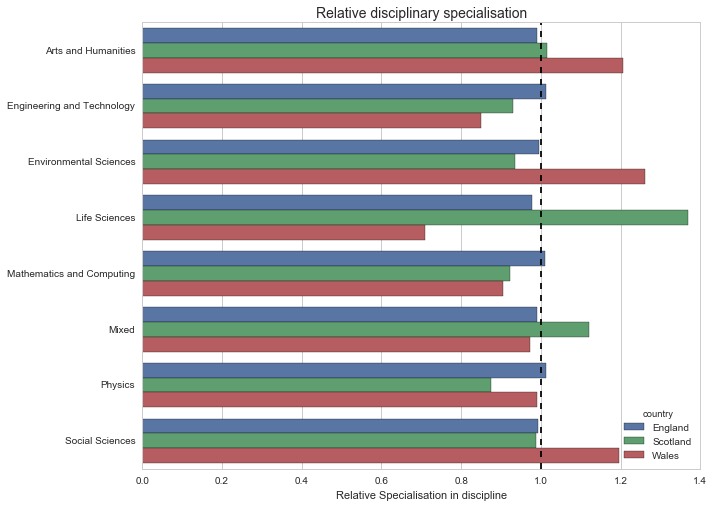

In [244]:
#Create cross_tab
topic_ct = pd.crosstab(places_projects_orgs_df.country,places_projects_orgs_df.topic_classified)

topic_country_to_plot = pd.melt(get_lq(topic_ct),id_vars='country')

#Quick barplot
sns.set_style("whitegrid")
f,ax = plt.subplots(figsize=(10,8))

bp = sns.barplot(y="topic_classified",x="value",hue="country",data=topic_country_to_plot)
bp.axvline(x=1,color="black",linestyle="dashed")
bp.set_title("Relative disciplinary specialisation",size=14)
ax.set(xlabel="Relative Specialisation in discipline",ylabel="")

In [232]:
#Do this by organisation (focusing on Welsh LADs)
area_lq = get_lq(pd.crosstab(places_projects_orgs_df['lad_name'],places_projects_orgs_df['topic_classified']))
area_lq[[i in welsh_lads for i in area_lq['lad_name']]]

topic_classified,lad_name,Arts and Humanities,Engineering and Technology,Environmental Sciences,Life Sciences,Mathematics and Computing,Mixed,Physics,Social Sciences
24,Blaenau Gwent,0.000000,2.091977,0.000000,0.000000,0.000000,2.019926,0.000000,0.000000
35,Bridgend,0.000000,1.267865,0.000000,2.005407,4.427654,0.000000,0.000000,0.754375
45,Caerphilly,0.000000,1.355911,2.019500,0.000000,3.246946,0.280545,0.000000,0.000000
51,Cardiff,0.933424,0.874045,0.933673,0.725243,0.640494,0.906200,1.604108,1.761931
53,Carmarthenshire,2.129372,1.045988,0.000000,0.000000,0.000000,1.009963,0.000000,2.489438
56,Ceredigion,2.591300,0.332060,1.634833,1.867469,0.824621,1.148900,0.123915,0.658582
72,Conwy,0.000000,0.000000,3.029250,0.000000,0.000000,3.366544,0.000000,0.000000
86,Denbighshire,0.000000,2.556861,0.000000,0.000000,0.000000,1.009963,1.561331,0.000000
122,Flintshire,0.000000,2.440640,1.817550,0.000000,0.000000,0.504982,0.000000,0.000000
134,Gwynedd,1.801777,0.339723,3.169061,0.452502,0.449577,0.958170,0.000000,1.063862


### Revised network analysis:
* Assortativity analysis
 * Extract the Welsh and UK networks using the network extraction function, and compare the matrices.
* Network plotting (harder). Subset the projects_org_places df by location (to capture all Welsh org ties) and produce a network. Subset and compare what this looks like depending on discipline (subset network by subject linl)?


In [321]:
#Topic networks
#Only focus on projects with topics
places_projects_topics_df= places_projects_orgs_df[places_projects_orgs_df['topic_list'].notnull()]

#Extract Welsh Network
welsh_n =extract_network_from_corpus(places_projects_topics_df.ix[places_projects_topics_df.country=="Wales","topic_list"])

#Relabel the nodes using the right category
for node in welsh_n.node:
    welsh_n.node[node]['category']= grouped_topics_dict[topic_communities[node]]
    
#Create an assortivity matrix.

#This dict indexes category names vs matrix indices (we'll use it later for relabelling)
index_cat_map = {v:k for k,v in grouped_topics_dict.iteritems()}
# Extract index labels for df below. !!! This is hacky
index_labels = pd.DataFrame(index_cat_map,index=[1]).T.sort(columns=1,ascending=True).index

#Create assortativity matrix
welsh_ass_mat = nx.attribute_mixing_matrix(welsh_n,attribute="category",normalized=True,mapping=index_cat_map)

#Put it into a dataframe
welsh_ass_df = pd.DataFrame(welsh_ass_m,index=index_labels,columns=index_labels).fillna(value=0)

#Do the same thing for UK wide network (repeating ourselves...)
#Extract newtork
uk_n = extract_network_from_corpus(places_projects_topics_df['topic_list'])

#Create category labels using our previously created dicts
for node in uk_n.node:
    uk_n.node[node]['category'] = grouped_topics_dict[topic_communities[node]]
    
#Create assortativity matrix
uk_ass_mat = nx.attribute_mixing_matrix(uk_n,attribute="category",normalized=True,mapping=index_cat_map)
uk_ass_df = pd.DataFrame(uk_ass_mat,index=index_labels,columns=index_labels)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


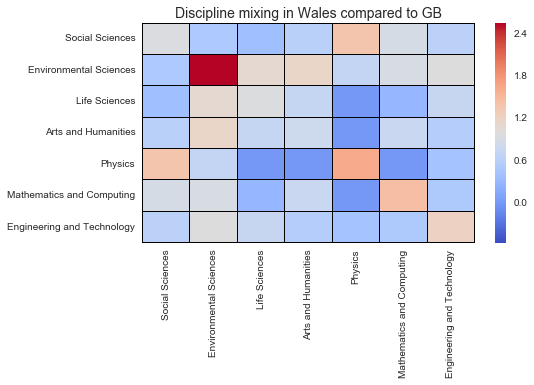

In [350]:
#Produce heatmap
fig,ax = plt.subplots()
hm = sns.heatmap(welsh_ass_df/uk_ass_df,cmap="coolwarm",center=1,linecolor="black",linewidths=0.01)
hm.set_title("Discipline mixing in Wales compared to GB",size=14)
fig.tight_layout()
plt.savefig("discipline_heatmap.png")

# !!! Todo: check the definition of the assortativity matrix. How are the probabilities calculated?

In [355]:
org_network_df = places_projects_topics_df[['project_id','name','org_id','lad_name','country',
                                            'topic_list','aggregated_topics','topic_classified']]

In [416]:
#How do we create this network?
#Simple way: subset by topic and area, collapse organisations and create network. Then add location.

#Need to group first.
orgs_grouped_by_project = org_network_df.groupby('project_id')

#Extract Welsh ids with a list comprehension that tests if Wales appears at least one in the list of countries
    #involved in the project
welsh_ids = [name for name,group in orgs_grouped_by_project if "Wales" in list(group.country)]

#Subset the data
org_network_welsh_df = org_network_df[[i in welsh_ids for i in org_network_df['project_id']]]
org_network_welsh_df.head()

In [471]:
#Lets' map the Welsh collaboration network in Physics.
w_physics_projects_df = org_network_welsh_df[org_network_welsh_df.topic_classified=="Engineering and Technology"]

w_physics_network = extract_network_from_corpus(w_physics_projects_df.groupby('project_id')['name'].apply(lambda x: list(x)))

for node in w_physics_network.node:
    w_physics_network.node[node]['country']=org_geo_lu_dict[node]['CTRY13NM']
    w_physics_network.node[node]['lad']=org_geo_lu_dict[node]['LAD13NM']
    
nx.write_graphml(w_physics_network,"w_mixed.graphml")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
